# LobbyView Package Vignette: Investigative Journalism
## Following the Money: A Deep Dive into the Dodd-Frank Act

This vignette demonstrates how investigative journalists can use the LobbyView Python package to uncover the story behind major legislation. Using the Dodd-Frank Wall Street Reform and Consumer Protection Act as our case study, we'll show how to:

- Track who lobbied for and against major legislation
- Identify key players and their connections
- Follow lobbying patterns over time
- Uncover the networks of influence

This type of analysis is valuable for:

- Investigative journalists tracking financial legislation
- Policy researchers studying corporate influence
- Watchdog groups monitoring legislative influence
- Anyone interested in transparency in lawmaking

## Setup

First, we'll configure our environment and connect to the LobbyView API. This gives us access to comprehensive lobbying data that would otherwise require manual collection from multiple government databases. We'll be doing our function calls to retrieve data using our initialized `lobbyview = LobbyView(LOBBYVIEW_TOKEN)` object.

In [12]:
import os
import sys
from dotenv import load_dotenv
sys.path.append('../src/lobbyview/')
from LobbyView import LobbyView

# Load environment variables and set up LobbyView
load_dotenv('../../.env')

LOBBYVIEW_TOKEN = os.environ.get('LOBBYVIEW_TOKEN', "NO TOKEN FOUND")
lobbyview = LobbyView(LOBBYVIEW_TOKEN)

## Identifying Our Target: The Dodd-Frank Act

The first step in our investigation is to locate the specific bill. The Dodd-Frank Wall Street Reform and Consumer Protection Act was introduced as H.R. 4173 in the 111th Congress.

The `bills()` method allows us to search by:

- Congress number
- Bill chamber ("H" for House, "S" for Senate)
- Bill number
- Bill status
- Date ranges

This flexibility helps journalists quickly locate any piece of legislation they're investigating.

In [13]:
# Investigate the Dodd-Frank Wall Street Reform and Consumer Protection Act
# This bill was introduced in the 111th Congress as H.R. 4173

# 1. Get bill information
bill_info = lobbyview.bills(congress_number=111, bill_chamber="H", bill_number=4173)
bill_data = bill_info.data[0]
print(f"Bill Information: {bill_data['bill_number']} - {bill_data['bill_state']}")

Bill Information: 4173 - ENACTED:SIGNED


## Following the Money: Who's Behind the Bill?

Every bill has a sponsor - a legislator who introduced it. Understanding who sponsored the bill and their connections is crucial for any investigation.

The `legislators()` method provides:

- Biographical information
- Historical data
- Unique identifiers that help us track connections
- Related legislative activity

In [14]:
# 2. Get sponsor information
sponsor_info = lobbyview.legislators(legislator_id=bill_data['legislator_id'])
sponsor_data = sponsor_info.data[0]
print(f"\nBill Sponsor: {sponsor_data['legislator_full_name']}")


Bill Sponsor: Barney Frank


## Uncovering the Lobbying Network

Now we get to the heart of our investigation: who lobbied on this bill? The `bill_client_networks()` method reveals the connections between bills and lobbying clients.

This data helps answer crucial questions:

- Which organizations lobbied on this bill?
- How intensively did they lobby?
- What positions did they take?
- How did their lobbying evolve over time?

In [15]:
# 3. Get lobbying data
bill_client_networks = lobbyview.bill_client_networks(congress_number=111, bill_chamber="H", bill_number=4173)

## Who Were the Major Players?

We'll identify the most active lobbying clients and get detailed information about each one. This helps us understand which organizations had the biggest stake in the legislation.

The `clients()` method helps us:

- Convert client IDs to readable names
- Get industry information
- Understand the scale of lobbying efforts
- Identify patterns in corporate influence

In [22]:
# 4. Analyze top lobbying clients
from collections import Counter, defaultdict

client_lobby_count = Counter(network['client_uuid'] for network in bill_client_networks)
top_clients = client_lobby_count.most_common(10)

client_names = {}
for client_uuid, _ in top_clients:
    client_info = lobbyview.clients(client_uuid=client_uuid)
    client_names[client_uuid] = client_info.data[0]['client_name']

print("\nTop Lobbying Clients:")
for client_uuid, count in top_clients:
    print(f"{client_names[client_uuid]}: {count}")


Top Lobbying Clients:
AEGON USA, INC.: 12
ALLIANZ OF AMERICA CORPORATION/FIREMAN'S FUND INSURANCE: 4
Federal Home Loan Bank of Atlanta: 4
Consumer Credit Industry Association: 3
Interactive Advertising Bureau: 2
BARCLAYS BANK PLC & U.S. AFFILIATES: 2
Leonard Green & Partners, LP: 2
Alternative Investment Management Association: 2
Financial Services Roundtable: 2
FIRSTENERGY CORP: 2


## Following the Timeline

When did lobbying activity peak? Was there a surge before key votes? The timing of lobbying activities can reveal crucial parts of the story.

We'll analyze:

- Quarterly lobbying patterns
- Intensity of lobbying over time
- Critical periods of activity
- Relationship between lobbying and legislative events

In [23]:
# 5. Analyze lobbying intensity over time
lobbying_timeline = defaultdict(int)
for network in bill_client_networks:
    report = lobbyview.reports(report_uuid=network['report_uuid']).data[0]
    year = report['report_year']
    quarter = report['report_quarter_code']
    lobbying_timeline[f"{year} Q{quarter}"] += 1

print("\nLobbying Intensity Over Time:")
for period, count in lobbying_timeline.items():
    print(f"{period}: {count}")


Lobbying Intensity Over Time:
2010 Q3: 14
2009 Q4: 8
2010 Q1: 15
2018 Q1: 3
2014 Q3: 3
2016 Q1: 2
2019 Q3: 3
2011 Q3: 2
2019 Q4: 1
2012 Q3: 6
2010 Q2: 13
2011 Q1: 6
2011 Q2: 2
2010 Q4: 8
2012 Q1: 2
2016 Q2: 4
2013 Q2: 2
2012 Q4: 1
2016 Q3: 3
2014 Q4: 2


## What Were They Lobbying About?

The `issues()` method helps us understand the specific aspects of the bill that attracted attention. This can reveal:

- Main points of contention
- Industry concerns
- Regulatory focus areas
- Target agencies and committees

In [24]:
# 6. Analyze issues and government entities
all_issues = []
for network in bill_client_networks:
    issues = lobbyview.issues(report_uuid=network['report_uuid'])
    all_issues.extend(issues.data)
issue_codes = Counter(issue['issue_code'] for issue in all_issues)
gov_entities = []
for issue in all_issues:
    if issue['gov_entity']:
        for entity in issue['gov_entity']:
            if entity:
                gov_entities.append(entity)

gov_entities = Counter(gov_entities)

print("\nTop Issues:")
for issue_code, count in issue_codes.most_common(10):
    print(f"{issue_code}: {count}")

print("\nTop Government Entities:")
for entity, count in gov_entities.most_common(10):
    print(f"{entity}: {count}")


Top Issues:
FIN: 70
TAX: 58
BAN: 30
INS: 30
RET: 26
CSP: 25
ENG: 19
BUD: 13
ENV: 13
HCR: 12

Top Government Entities:
HOUSE OF REPRESENTATIVES: 432
SENATE: 431
DEPARTMENT OF THE TREASURY: 43
SECURITIES AND EXCHANGE COMMISSION: 20
WHITE HOUSE: 18
ENVIRONMENTAL PROTECTION AGENCY: 13
DEPARTMENT OF AGRICULTURE: 11
DEPARTMENT OF LABOR: 10
DEPARTMENT OF HEALTH AND HUMAN SERVICES: 10
NATIONAL ECONOMIC COUNCIL: 8


## Connecting the Dots: Legislative Networks

For the most active lobbying clients, we'll examine their broader legislative connections. The `networks()` method reveals:

- Key legislative relationships
- Patterns of influence
- Strategic lobbying approaches
- Long-term political relationships

In [25]:
# 7. Analyze network connections
legislator_connections = defaultdict(int)
for network in lobbyview.networks(client_uuid=top_clients[0][0]):
    legislator_connections[network['legislator_id']] += network['n_bills_sponsored']

top_legislators = sorted(legislator_connections.items(), key=lambda x: x[1], reverse=True)[:5]
legislator_names = {}
for leg_id, _ in top_legislators:
    leg_info = lobbyview.legislators(legislator_id=leg_id)
    legislator_names[leg_id] = leg_info.data[0]['legislator_full_name']

print("\nTop Legislators Connected to Top Lobbying Client:")
for leg_id, count in top_legislators:
    print(f"{legislator_names[leg_id]}: {count}")


Top Legislators Connected to Top Lobbying Client:
Susan M. Collins: 82
Sherrod Brown: 36
John Conyers, Jr.: 30
Jeff Bingaman: 25
Richard Blumenthal: 22


## Visualizing the Story

Data visualization helps us communicate complex lobbying patterns to readers. We'll create a comprehensive set of visualizations that show:

- Lobbying intensity over time
- Top players and their activities
- Key issues and focus areas
- Government entities targeted
- Legislative connections

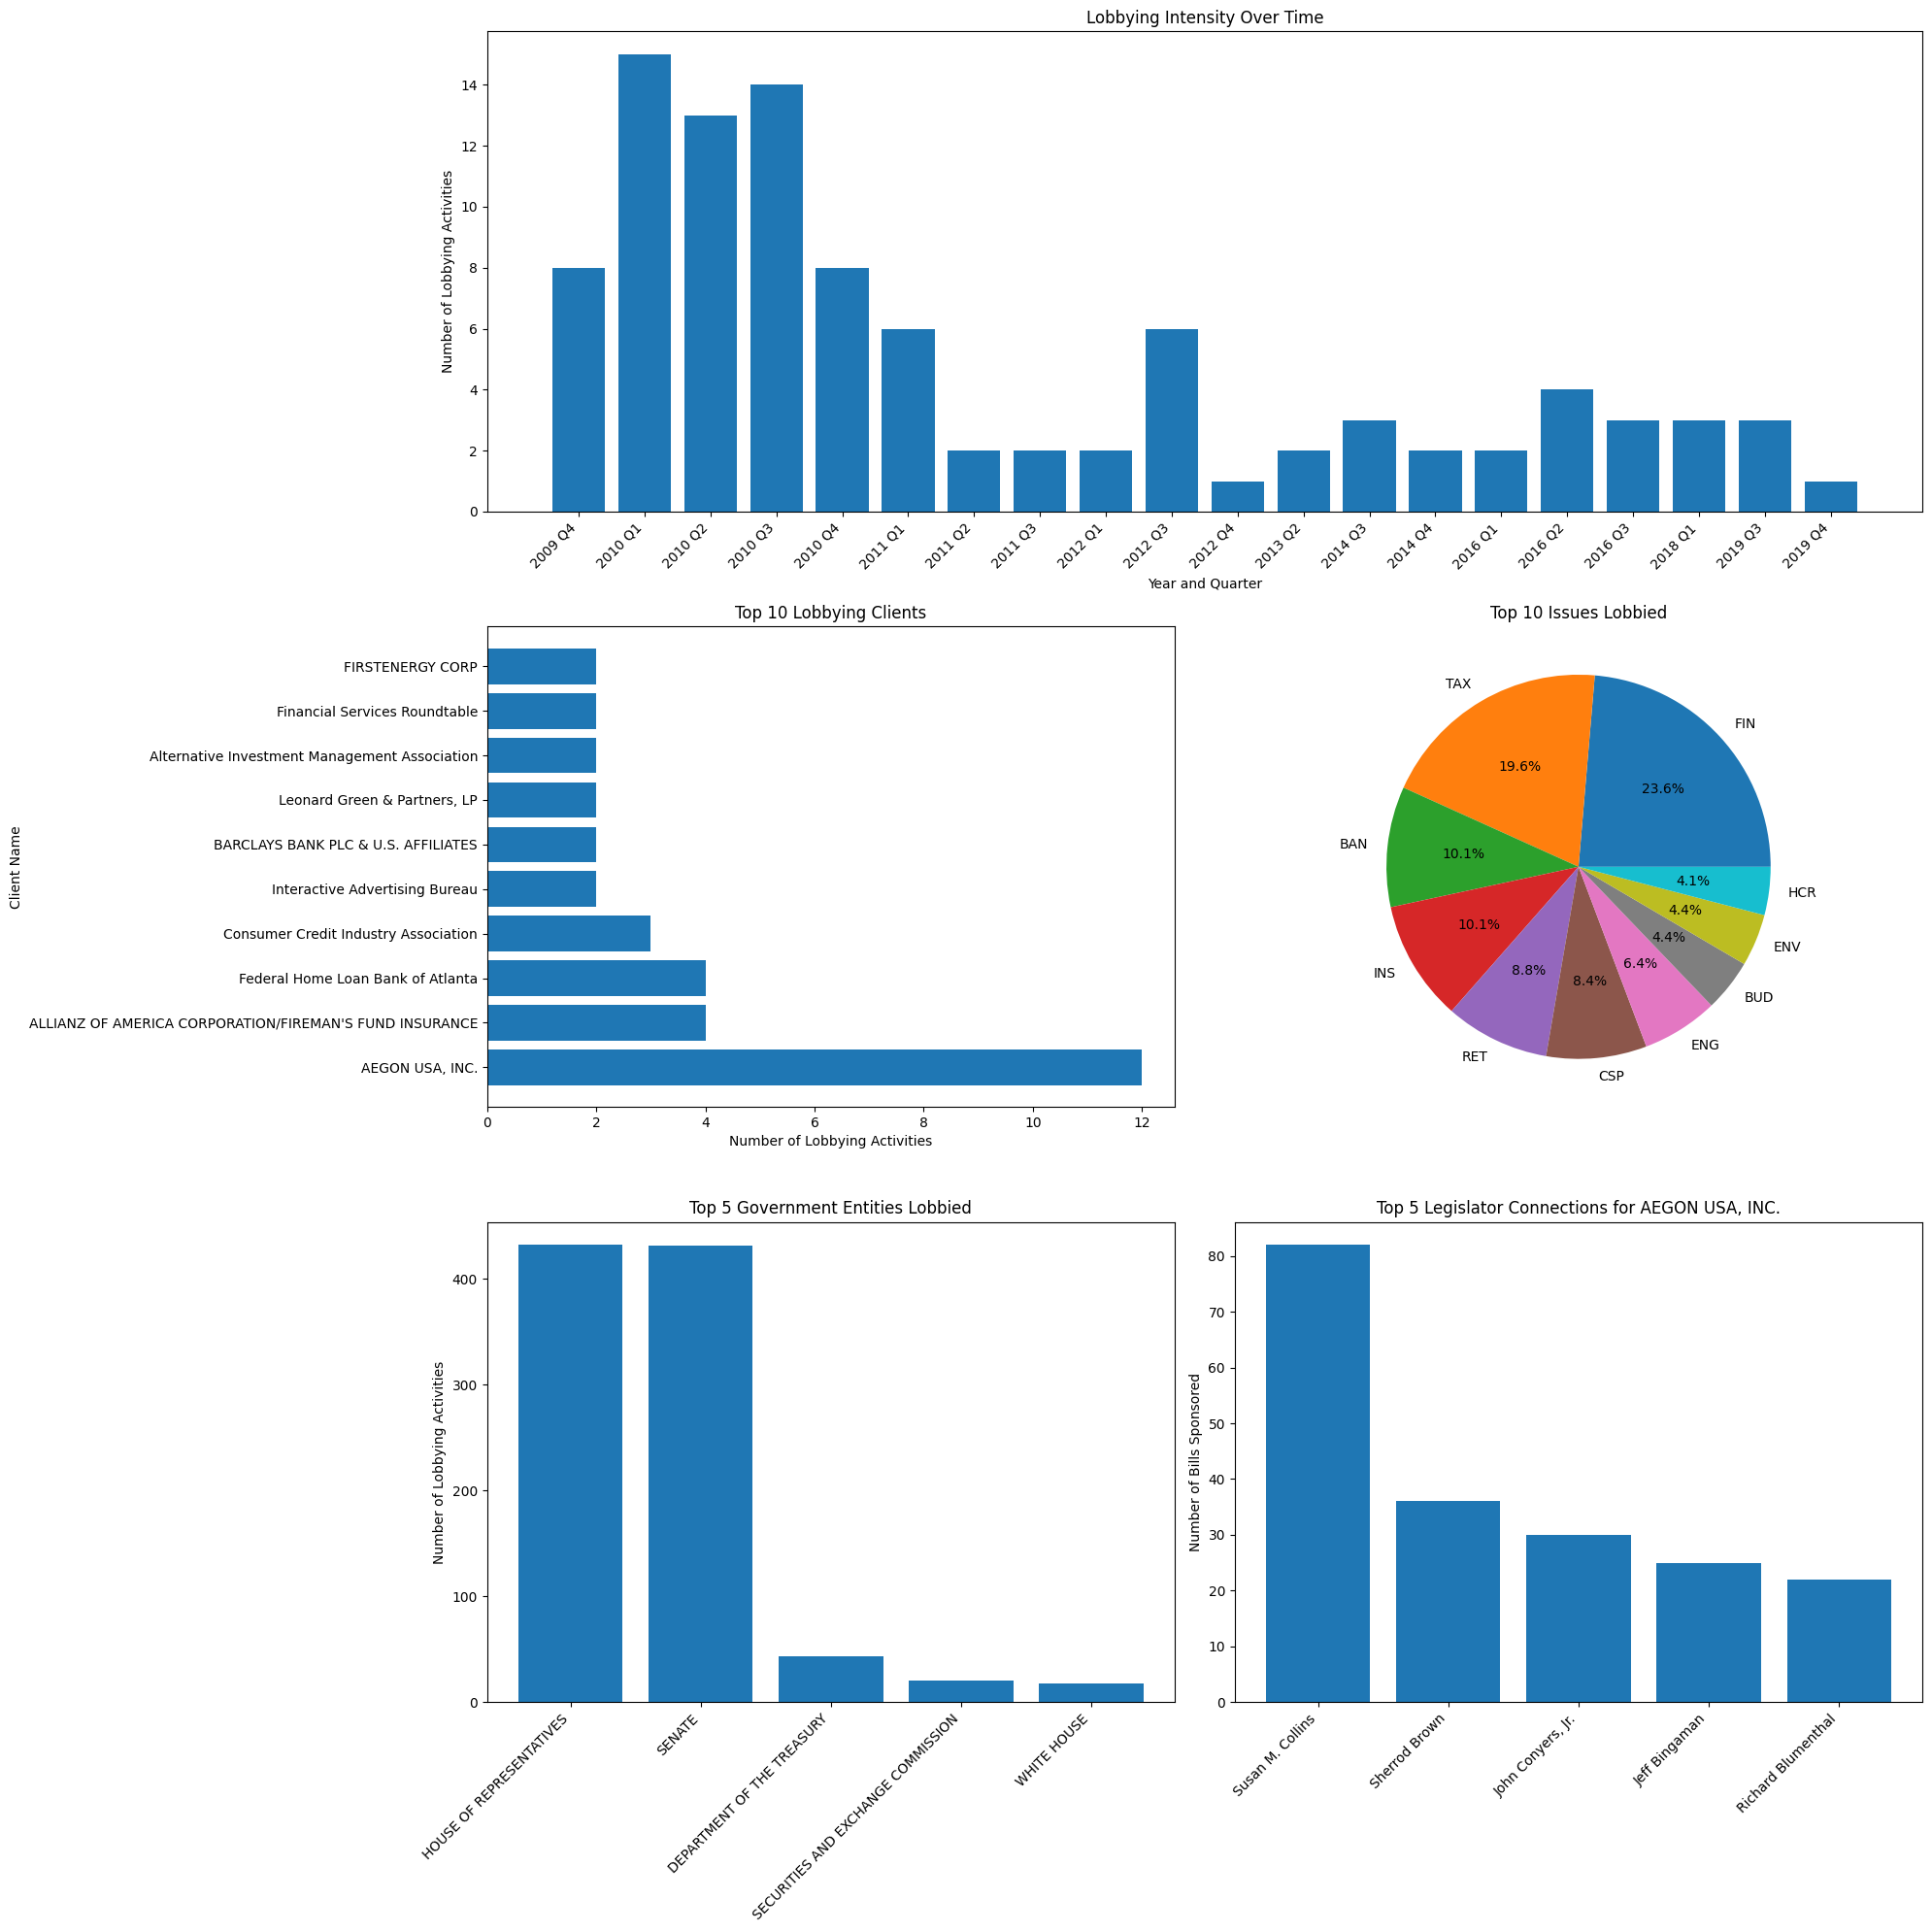

In [28]:
# Create comprehensive visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.figure(figsize=(20, 20))
gs = GridSpec(3, 2, figure=plt.gcf())

# 1. Lobbying Intensity Over Time
ax1 = plt.subplot(gs[0, :])
sorted_timeline = dict(sorted(lobbying_timeline.items()))
ax1.bar(sorted_timeline.keys(), sorted_timeline.values())
ax1.set_title("Lobbying Intensity Over Time")
ax1.set_xlabel("Year and Quarter")
ax1.set_ylabel("Number of Lobbying Activities")
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right")

# 2. Top Lobbying Clients
ax2 = plt.subplot(gs[1, 0])
client_names_list = [client_names[uuid] for uuid, _ in top_clients]
client_counts = [count for _, count in top_clients]
ax2.barh(client_names_list, client_counts)
ax2.set_title("Top 10 Lobbying Clients")
ax2.set_xlabel("Number of Lobbying Activities")
ax2.set_ylabel("Client Name")

# 3. Top Issues Lobbied
ax3 = plt.subplot(gs[1, 1])
top_issues = issue_codes.most_common(10)
ax3.pie([count for _, count in top_issues], labels=[issue for issue, _ in top_issues], autopct='%1.1f%%')
ax3.set_title("Top 10 Issues Lobbied")

# 4. Top Government Entities Lobbied
ax4 = plt.subplot(gs[2, 0])
top_entities = gov_entities.most_common(5)
ax4.bar([entity for entity, _ in top_entities], [count for _, count in top_entities])
ax4.set_title("Top 5 Government Entities Lobbied")
ax4.set_ylabel("Number of Lobbying Activities")
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha="right")

# 5. Top Legislator Connections for Main Lobbying Client
ax5 = plt.subplot(gs[2, 1])
ax5.bar([legislator_names[leg_id] for leg_id, _ in top_legislators],
        [count for _, count in top_legislators])
ax5.set_title(f"Top 5 Legislator Connections for {client_names[top_clients[0][0]]}")
ax5.set_ylabel("Number of Bills Sponsored")
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


## Putting It All Together: Key Findings

Finally, we'll summarize the key findings that could form the basis of an investigative piece. This brings together all aspects of our analysis to tell a compelling story about influence and legislation.

In [27]:
print("\nA comprehensive analysis of lobbying activity has been saved as 'dodd_frank_lobbying_analysis.png'")

# Journalist's Key Findings
print("\nKey Findings for Investigative Piece:")
print(f"1. The Dodd-Frank Act (H.R. 4173) was sponsored by {sponsor_data['legislator_full_name']}.")
print(f"2. The bill's current state is: {bill_data['bill_state']}")
print(f"3. The most active lobbying client was {client_names[top_clients[0][0]]}, with {top_clients[0][1]} lobbying activities.")
print(f"4. Lobbying activity peaked in {max(lobbying_timeline, key=lobbying_timeline.get)}, with {max(lobbying_timeline.values())} activities.")
print(f"5. The most lobbied issue was '{top_issues[0][0]}', accounting for {top_issues[0][1]} activities.")
print(f"6. The government entity most frequently lobbied was {top_entities[0][0]}, targeted {top_entities[0][1]} times.")
print(f"7. For the top lobbying client, the legislator most frequently connected to sponsored bills was {legislator_names[top_legislators[0][0]]}, with {top_legislators[0][1]} bills.")


A comprehensive analysis of lobbying activity has been saved as 'dodd_frank_lobbying_analysis.png'

Key Findings for Investigative Piece:
1. The Dodd-Frank Act (H.R. 4173) was sponsored by Barney Frank.
2. The bill's current state is: ENACTED:SIGNED
3. The most active lobbying client was AEGON USA, INC., with 12 lobbying activities.
4. Lobbying activity peaked in 2010 Q1, with 15 activities.
5. The most lobbied issue was 'FIN', accounting for 70 activities.
6. The government entity most frequently lobbied was HOUSE OF REPRESENTATIVES, targeted 432 times.
7. For the top lobbying client, the legislator most frequently connected to sponsored bills was Susan M. Collins, with 82 bills.
